# Predictive model

In [1]:
import xgboost as xgb
from inspect_tables import read_data
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from dataset_generator import binder_mov
idx = pd.IndexSlice

## Primo approccio esplorativo

Predizione di guasto su un Dataset sintetico che assuma tutte le fatture associate a un unico veicolo. Ogni fattura viene presentata al modello con un periodo $\Delta t$ di misiurazioni antecedente al guasto.
- $\Delta t$ viene posto a **1 mese**
- I dati sono al momento aggregati per ottenere **1 sample** al giorno (questa fase necessiterà di feature engineering)

Predire:
 1. Un guasto preso singolarmente (es. il più numeroso)
 2. Tutte le categorie insieme (i.e. predire una rottura qualsiasi)
 3. Modello multiclasse
 
 Modelli da testare:
  - XGBoost
  - Random Forest
  - LSTM
  - ...

In [2]:
dt=30
fatt_distance = 7
agg_funs = ["mean", "std", "min", "max", "count", "median"]
which_data = {
    "movimatica": binder_mov,
}

## Selezione Fatture

,ID,Targa,Data,Revisione,Tagliando,Categoria,Componente,Manutenzione
0,397,FV908SK,2021-05-12,No,No,Impianto di scarico,Filtro antiparticolato,Sostituzione
2,397,FV908SK,2021-05-12,No,No,Impianto di scarico,Dosatore riducente,Sostituzione
3,397,FV908SK,2021-05-12,No,No,Sensoristica,Taratura tachigrafo,-
4,398,FZ330SC,2021-05-13,No,No,Impianto lubrificazione motore,Ingrassaggio,Pulizia
5,398,FZ330SC,2021-05-13,No,No,Impianto lubrificazione motore,Lubrificazione,Pulizia


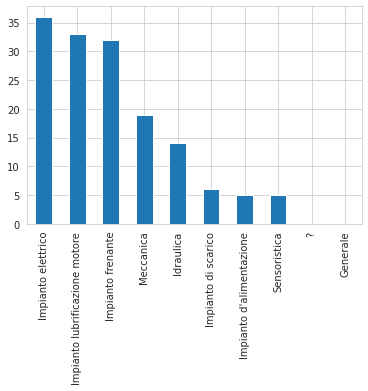

In [3]:
cat_fatture = pd.read_excel("excels/eventi_manutenzioni_esterne (da fatture).xlsx", sheet_name="Categorie", usecols="A:H").rename(columns={"Categoria componente": "Categoria"})

cat_fatture.Data = pd.to_datetime(cat_fatture.Data)
cat_fatture.Categoria = cat_fatture.Categoria.astype("category").apply(lambda x: x if x != "Impianto di lubrificazione motore" else "Impianto lubrificazione motore")
cat_fatture = cat_fatture[~cat_fatture.Categoria.isin(["?", "Generale"])&(cat_fatture.Tagliando == "No")]
g = cat_fatture.Categoria.value_counts().plot(kind="bar")
cat_fatture.head()

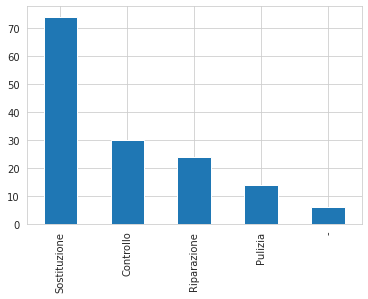

In [4]:
g = cat_fatture.Manutenzione.value_counts().plot(kind="bar")

⚠️ Valutare se considerare solo alcune di queste tipologie

In [5]:
len(cat_fatture)

150

Da queste fatture vogliamo eliminare tutte quelle che hanno una fattura dello stesso tipo su quel veicolo entro un periodo di **7 giorni**

Solo 17 fatture sono precedute da una dello stesso tipo per la stessa targa.
Il numero di fatture considerate diventa ora 98


ID       Data Revisione Tagliando  \
Categoria Targa                                         
Idraulica FV907SK  438 2021-07-20        No        No   
          FV908SK  420 2021-06-24        No        No   
          FV913SK  480 2021-09-24        No        No   
          FV986FV  402 2021-05-22        No        No   
          FV988FV  436 2021-07-16        No        No   

                                                Componente  Manutenzione  \
Categoria Targa                                                            
Idraulica FV907SK                       Impianto idraulico     Controllo   
          FV908SK                          Manicotto acqua   Riparazione   
          FV913SK                      Impianto idraulico      Controllo   
          FV986FV  Supporto per bobina magnetico idraulico  Sostituzione   
          FV988FV                      Impianto idraulico   Sostituzione   

                   delta  
Categoria Targa           
Idraulica FV907SK    NaN  
          FV908SK    NaN  
          FV913SK    NaN  
          FV986FV    NaN  
          FV988FV    NaN

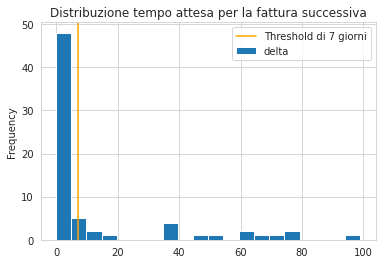

In [6]:
df_fatture =  cat_fatture.set_index(["Categoria", "Targa"]).sort_values(by="Data").sort_index()
df_fatture['delta'] = np.inf
idx = pd.IndexSlice

for ix in df_fatture.index:
    df_fatture.loc[ idx[ix], 'delta'] = df_fatture.loc[idx[ix], 'Data' ].diff().dt.days

d = df_fatture.delta.plot(kind="hist", bins=20, title="Distribuzione tempo attesa per la fattura successiva")  
d.axvline(fatt_distance,c="orange", label=f"Threshold di {fatt_distance} giorni")
plt.legend()
df_fatture = df_fatture[df_fatture.delta.isna()|(df_fatture.delta > fatt_distance)]

print(f"Solo {len(df_fatture[df_fatture.delta > 7])} fatture sono precedute da una dello stesso tipo per la stessa targa.\n\
Il numero di fatture considerate diventa ora {df_fatture.shape[0]}")
df_fatture.head()

⚠️ **Il mese considerato non deve contenere altre rotture**
Tutte le fatture (di qualsiasi tipologia) che avvengono prima di $\Delta t$ dalla rottura precedente velgono ulteriormente rimosse.

**Assunzione:** Le fatture dello stesso giorno ma di tipologia diversa vengono per il momento mantenute, nel caso del modello a classe singola se ne potrebbe considerare solo una per ogni data

In [7]:
df_fatture = df_fatture.reset_index().sort_values(by=["Targa", "Data"])
less_thr = df_fatture.groupby("Targa").apply(lambda x: x.Data.diff().dt.days.between(0, dt, inclusive='right'))
df_fatture = df_fatture.drop(less_thr.index[less_thr].get_level_values(1))
df_fatture

,Categoria,Targa,ID,Data,Revisione,Tagliando,Componente,Manutenzione,delta
66,Impianto frenante,CW363HC,435,2021-07-10,No,No,Pinze freni,Sostituzione,NaN
16,Impianto lubrificazione motore,CW365HC,469,2021-09-10,No,No,Pompa,Sostituzione,NaN
42,Impianto elettrico,CW365HC,469,2021-09-10,No,No,Batteria e Avviamento,Sostituzione,NaN
81,Meccanica,CW365HC,469,2021-09-10,No,No,Balestre,Sostituzione,NaN
17,Impianto lubrificazione motore,EN971TN,416,2021-06-15,Si,No,Paraolio,Sostituzione,NaN
...,...,...,...,...,...,...,...,...,...
10,Idraulica,ZB478AN,401,2021-05-17,No,No,Valvola distributore,Sostituzione,NaN
37,Impianto lubrificazione motore,ZB478AN,401,2021-05-17,No,No,Rabbocco olio idraulico,Sostituzione,NaN
91,Meccanica,ZB478AN,401,2021-05-17,No,No,Pistone vasca,Sostituzione,NaN
11,Idraulica,ZB478AN,439,2021-07-24,No,No,Valvola pistone,Sostituzione,68.0


## Costruzione Dataset

A partire dai dati dei 3 fornitori principali, si possono definire le serie temporali che tengano informazioni su, min, max, media, count, percentili:

|                     | Movimatica     | Scania            |  Visirun   |
| -----------         | :---------:    | :---------:       | :------:   |
| **odometro**        | odometer       | Odometer          | odometer   |
| **velocità**        | position_speed | AverageSpeed      | speed      |
| **tempo attività**  | engineHours    | EngineRunningTime | workMinutes|

 - Aggregation **giornaliera**
 - Nel caso di più fornitori: merge
 - Feature selection con pearson-correlation (> $thr$)

Eliminati 1272 record anomali antecedenti al 2021 (in date 03/10/2020)
              plate  odometer  position_speed  engineHours           timestamp
date                                                                          
2021-05-11  ZB478AN     30349              12         4514 2021-05-11 07:34:28
2021-05-11  ZB476AN     37532               0         4426 2021-05-11 09:26:41
2021-05-11  ZB477AN     24933               1         3497 2021-05-11 09:20:15
2021-05-11  ZB127AR     63197               0         1395 2021-05-11 10:40:38
2021-05-11  FV914SK     11308               1          959 2021-05-11 13:08:58
| Movimatica: (12910, 5) |


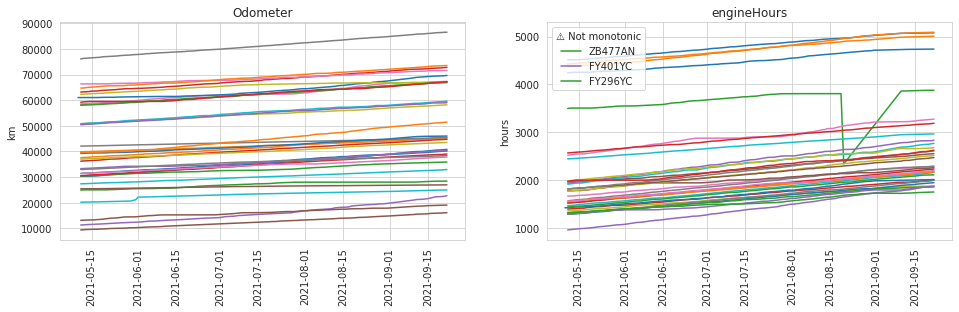

In [8]:
data_mov = binder_mov(debug=True)

In [9]:
data_mov.head()

odometer_mean  odometer_std  odometer_min  odometer_max  \
plate   date                                                                  
FV903SK 2021-05-11        62300.0           NaN       62300.0       62300.0   
        2021-05-12        62348.0           NaN       62348.0       62348.0   
        2021-05-13        62382.0     45.738387       62348.0       62434.0   
        2021-05-14        62479.5     53.033009       62442.0       62517.0   
        2021-05-15        62560.0     45.254834       62528.0       62592.0   

                    odometer_count  odometer_median  position_speed_mean  \
plate   date                                                               
FV903SK 2021-05-11               1          62300.0                  0.0   
        2021-05-12               1          62348.0                  1.0   
        2021-05-13               3          62364.0                 10.0   
        2021-05-14               2          62479.5                  3.0   
        2021-05-15               2          62560.0                  0.0   

                    position_speed_std  position_speed_min  \
plate   date                                                 
FV903SK 2021-05-11                 NaN                 0.0   
        2021-05-12                 NaN                 1.0   
        2021-05-13           17.320508                 0.0   
        2021-05-14            4.242641                 0.0   
        2021-05-15            0.000000                 0.0   

                    position_speed_max  position_speed_count  \
plate   date                                                   
FV903SK 2021-05-11                 0.0                     1   
        2021-05-12                 1.0                     1   
        2021-05-13                30.0                     3   
        2021-05-14                 6.0                     2   
        2021-05-15                 0.0                     2   

                    position_speed_median  engineHours_mean  engineHours_std  \
plate   date                                                                   
FV903SK 2021-05-11                    0.0       1986.000000              NaN   
        2021-05-12                    1.0       1992.000000              NaN   
        2021-05-13                    0.0       1995.333333         4.163332   
        2021-05-14                    3.0       2002.500000         3.535534   
        2021-05-15                    0.0       2008.500000         3.535534   

                    engineHours_min  engineHours_max  engineHours_count  \
plate   date                                                              
FV903SK 2021-05-11           1986.0           1986.0                  1   
        2021-05-12           1992.0           1992.0                  1   
        2021-05-13           1992.0           2000.0                  3   
        2021-05-14           2000.0           2005.0                  2   
        2021-05-15           2006.0           2011.0                  2   

                    engineHours_median  
plate   date                            
FV903SK 2021-05-11              1986.0  
        2021-05-12              1992.0  
        2021-05-13              1994.0  
        2021-05-14              2002.5  
        2021-05-15              2008.5

---
## Alternative idea

In [ ]:
df = data_mov.set_index(["plate"]).sort_values(by=["plate", "timestamp"])
df['d_odometer'] = np.NaN
df['d_enginehours'] = np.NaN
df['timedelta'] = np.NaN

for ix in df.index.unique():
    df.loc[ idx[ix], 'd_odometer'] = df.loc[idx[ix], 'odometer' ].diff()
    df.loc[ idx[ix], 'd_enginehours'] = df.loc[idx[ix], 'engineHours' ].diff()
    df.loc[ idx[ix], 'timedelta'] = df.loc[idx[ix], 'timestamp' ].diff().dt.total_seconds() / 3600


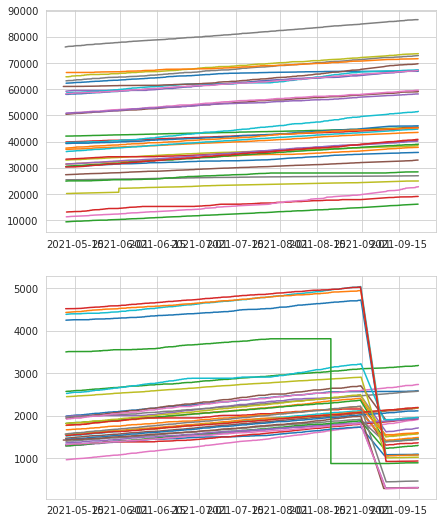

In [225]:
fig, ax = plt.subplots(2, 1, figsize= (7,9))
for ix in df.index.unique():
    ax[0].plot("timestamp","odometer", data = df.loc[idx[ix], :])
    ax[1].plot("timestamp","engineHours_2", data = df.loc[idx[ix], :])    

---
## Feature Engineering and Selection

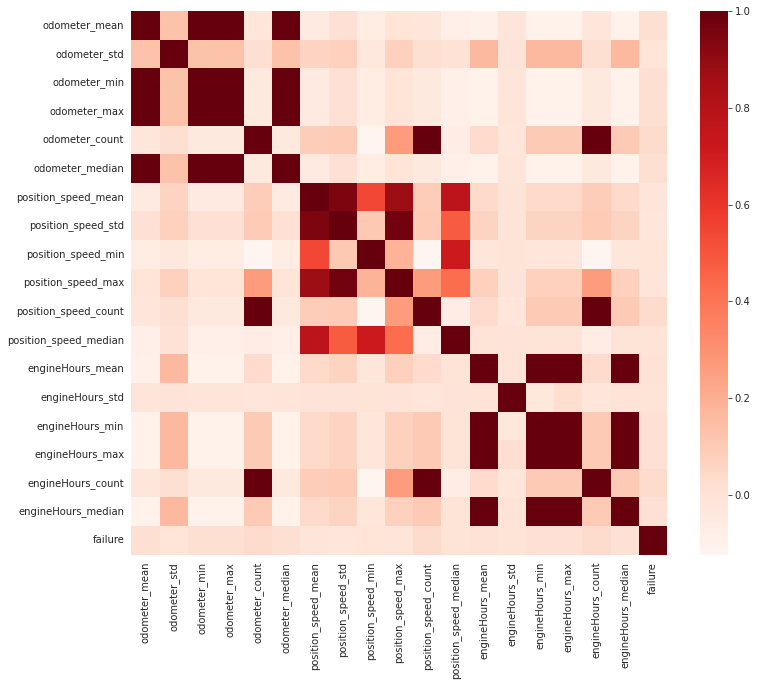

In [150]:
plt.figure(figsize=(12,10))

failures = df_interpol.index.isin(df_fatture.set_index(["Targa", "Data"]).index.unique())
corr = df_interpol.assign(failure=failures).corr()

sns.heatmap(corr, cmap=plt.cm.Reds)
plt.show()

In [158]:
keep = np.triu(np.ones(corr.shape)).astype('bool').reshape(corr.size)
melt = corr.stack()[keep]
melt

odometer_mean       odometer_mean         1.000000
                    odometer_std          0.131299
                    odometer_min          0.999999
                    odometer_max          0.999999
                    odometer_count       -0.019109
                                            ...   
engineHours_count   engineHours_median    0.102817
                    failure               0.031167
engineHours_median  engineHours_median    1.000000
                    failure               0.010071
failure             failure               1.000000
Length: 190, dtype: float64

In [129]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(thrsort_values)

odometer                                              \
                       mean        std      min      max count   median   
plate   date                                                              
FV903SK 2021-05-11  62300.0        NaN  62300.0  62300.0     1  62300.0   
        2021-05-12  62348.0        NaN  62348.0  62348.0     1  62348.0   
        2021-05-13  62382.0  45.738387  62348.0  62434.0     3  62364.0   

                   position_speed                                     \
                             mean        std  min   max count median   
plate   date                                                           
FV903SK 2021-05-11            0.0        NaN  0.0   0.0     1    0.0   
        2021-05-12            1.0        NaN  1.0   1.0     1    1.0   
        2021-05-13           10.0  17.320508  0.0  30.0     3    0.0   

                    engineHours                                          
                           mean       std     min     max count  median  
plate   date                                                             
FV903SK 2021-05-11  1986.000000       NaN  1986.0  1986.0     1  1986.0  
        2021-05-12  1992.000000       NaN  1992.0  1992.0     1  1992.0  
        2021-05-13  1995.333333  4.163332  1992.0  2000.0     3  1994.0

In [128]:
dataset = []
for i, row in tqdm(df_fatture.iterrows(), desc="Dataset generation", total=df_fatture.shape[0]):
    if row.Targa in df_interpol.index.get_level_values(0):
        series = df_interpol.xs(row.Targa, level=0).truncate(row.Data - pd.Timedelta(days=dt-1), row.Data)
        dataset.append({
            "time_series": series.assign(failure=(series.index == row.Data).astype(int)),
            "Categoria": row.Categoria,
            "Targa": row.Targa,
            "ID": row.ID,
            "Revisione": row.Revisione,
            "Tagliando": row.Tagliando,
            "Componente": row.Componente,
            "Manutenzione": row.Manutenzione,
        })
        
print(f"Dataset has {len(dataset)} time series")

Dataset generation: 100%|██████████| 87/87 [00:00<00:00, 758.34it/s]

Dataset has 54 time series
